In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns

from collections import defaultdict
from itertools import combinations, permutations
from matplotlib import rcParams
from os import listdir
from os.path import join
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, ttest_ind, fisher_exact, hypergeom
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

plot_dir = '../Data/Figures'
data_dir = '../Data/Data_Metabolic_reaction_analysis'

In [2]:
# Load AGORA taxa
df = pd.read_csv(data_dir + '/agora_taxa.tsv', delimiter='\t')
df['species'] = [x[1] for x in df.organism.str.split(' ')]
agora_tax_df = df
agora_tax_df

organism  \
0                     Abiotrophia defectiva ATCC 49176   
1                        Achromobacter xylosoxidans A8   
2    Achromobacter xylosoxidans NBRC 15126 = ATCC 2...   
3                 Acidaminococcus fermentans DSM 20731   
4                   Acidaminococcus intestini RyC-MR95   
..                                                 ...   
813                  Yersinia frederiksenii ATCC 33641   
814                   Yersinia kristensenii ATCC 33638   
815                  Yersinia pseudotuberculosis YPIII   
816                         Yersinia rohdei ATCC 43380   
817                  Yokenella regensburgei ATCC 43003   

                                              seedid   kingdom  \
0        Abiotrophia defectiva ATCC 49176 (592010.4)  Bacteria   
1           Achromobacter xylosoxidans A8 (762376.5)  Bacteria   
2                                                NaN  Bacteria   
3    Acidaminococcus fermentans DSM 20731 (591001.3)  Bacteria   
4      Acidaminococcus intestini RyC-MR95 (568816.4)  Bacteria   
..                                               ...       ...   
813     Yersinia frederiksenii ATCC 33641 (349966.3)  Bacteria   
814      Yersinia kristensenii ATCC 33638 (527012.3)  Bacteria   
815     Yersinia pseudotuberculosis YPIII (502800.3)  Bacteria   
816            Yersinia rohdei ATCC 43380 (527004.3)  Bacteria   
817    Yokenella regensburgei ATCC 43003 (1002368.3)  Bacteria   

             phylum               mclass              order  \
0        Firmicutes              Bacilli    Lactobacillales   
1    Proteobacteria   Betaproteobacteria    Burkholderiales   
2    Proteobacteria   Betaproteobacteria    Burkholderiales   
3        Firmicutes        Negativicutes  Acidaminococcales   
4        Firmicutes        Negativicutes    Selenomonadales   
..              ...                  ...                ...   
813  Proteobacteria  Gammaproteobacteria  Enterobacteriales   
814  Proteobacteria  Gammaproteobacteria  Enterobacteriales   
815  Proteobacteria  Gammaproteobacteria  Enterobacteriales   
816  Proteobacteria  Gammaproteobacteria  Enterobacteriales   
817  Proteobacteria  Gammaproteobacteria  Enterobacteriales   

                 family            genus            oxygenstat  \
0         Aerococcaceae      Abiotrophia  Facultative anaerobe   
1        Alcaligenaceae    Achromobacter                Aerobe   
2        Alcaligenaceae    Achromobacter                Aerobe   
3    Acidaminococcaceae  Acidaminococcus     Obligate anaerobe   
4    Acidaminococcaceae  Acidaminococcus     Obligate anaerobe   
..                  ...              ...                   ...   
813  Enterobacteriaceae         Yersinia  Facultative anaerobe   
814  Enterobacteriaceae         Yersinia                Aerobe   
815  Enterobacteriaceae         Yersinia  Facultative anaerobe   
816  Enterobacteriaceae         Yersinia     Obligate anaerobe   
817  Enterobacteriaceae        Yokenella  Facultative anaerobe   

                                     metabolism  ... reactions metabolites  \
0    Saccharolytic, fermentative or respiratory  ...      2428        1250   
1                                   Respiratory  ...      1668        1229   
2                                   Respiratory  ...      1674        1216   
3                                  Fermentative  ...      1102         905   
4        Asaccharolytic, glutamate is fermented  ...      1001         828   
..                                          ...  ...       ...         ...   
813                   Fermentative, respiratory  ...      1743        1212   
814                                 Respiratory  ...      1710        1188   
815                 Saccharolytic, fermentative  ...      1658        1184   
816                 Saccharolytic, fermentative  ...      1705        1187   
817  Saccharolytic, fermentative or respiratory  ...      2517        1587   

     draftcreator  draftcreated  phenotype         imgid     ncbiid  

In [3]:
# Load AGORA reactions and subsystems (needs to load all 818 models the first time)

subsys = defaultdict(set)

rxn_file = data_dir + '/agora_reactions.csv'
subsys_file = data_dir + '/agora_subsys.tsv'

try:
    rxn_df = pd.read_csv(rxn_file, index_col=0)
    
    with open(subsys_file, 'r') as f:
        for line in f:
            l = line.strip().split('\t')
            subsys[l[0]] = set(l[1:])
            
except FileNotFoundError:
    d = {}
    
    model_dir = 'models/AGORA-1.03-With-Mucins/sbml/'

    i = 0
    for x in listdir(model_dir):
        if x.endswith('.xml'):
            print(i, x)
            # Load model
            model = cobra.io.read_sbml_model(join(model_dir, x))
            
            # Get reactions
            d[model.id] = {r.id: 1 for r in model.reactions}
            
            # Get subsystems
            for g in model.groups:
                subsys[g.name] |= set(r.id for r in g.members)
            
            i += 1
                
    rxn_df = pd.DataFrame(d).fillna(0)
    
    # Save reactions
    rxn_df.to_csv(rxn_file)

    # Save subsystems
    with open(subsys_file, 'w') as f:
        for x in sorted(subsys):
            f.write(x + '\t')
            f.write('\t'.join(sorted(subsys[x])) + '\n')
                        
# Add mapping from reactions to subsystems
for x, s in dict(subsys).items():
    for r in s:
        subsys[r] = x
        
rxn_df = rxn_df[~rxn_df.index.str.contains('biomass')]
    
rxn_df, subsys

(           Abiotrophia_defectiva_ATCC_49176  Achromobacter_xylosoxidans_A8  \
 23DHMPO                                 1.0                            1.0   
 26DAPLLAT                               1.0                            0.0   
 2AHBUTI                                 1.0                            1.0   
 2MBCOATA                                1.0                            1.0   
 3HAD10M12                               1.0                            1.0   
 ...                                     ...                            ...   
 HICITD                                  0.0                            0.0   
 OXAG                                    0.0                            0.0   
 US7P1PT                                 0.0                            0.0   
 HYD5y                                   0.0                            0.0   
 THMDP                                   0.0                            0.0   
 
            Achromobacter_xylosoxidans_NBRC_15126 

In [4]:
agora_tax_df.nunique()

organism        818
seedid          649
kingdom           2
phylum           14
mclass           27
order            49
family           96
genus           227
oxygenstat       14
metabolism       76
gram              9
mtype             8
genes           527
reactions       590
metabolites     468
draftcreator      5
draftcreated     22
phenotype         5
imgid           633
ncbiid          816
platform          2
kbaseid         512
species         589
dtype: int64

['Actinobacteria', 'Bacteroidetes', 'Crenarchaeota', 'Cyanobacteria', 'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Planctomycetes', 'Proteobacteria', 'Spirochaetes', 'Synergistetes', 'Tenericutes', 'Thaumarchaeota', 'Verrucomicrobia']
['', 'Negative', 'Negative (inferred from sequence)', 'Negative due to the absence of a cell wall', 'Positive', 'Positive or negative', 'Structurally positive but may stain negative', 'Structurally positive but stains negative', 'Uncharacterized', 'Variable']
['', 'Aerobe', 'Aerobe, microaerophile', 'Aerotolerant', 'Anaerobe', 'Facultative anaerobe', 'Facultative anaerobe, air+CO2', 'Microaerophile', 'Microaerophile/ anaerobe', 'Microaerophilic', 'Nanaerobe', 'Obligate aerobe', 'Obligate anaerobe', 'Obligate anaerobe (inferred from sequence)', 'Obligatory anaerobe']
['', ' Saccharolytic, respiratory', 'Aaccharolytic, peptone and oligopeptides as main energy source', 'Asaccharolytic', 'Asaccharolytic, Fermentative', 'Asaccharolytic, fermentative', 'Asac

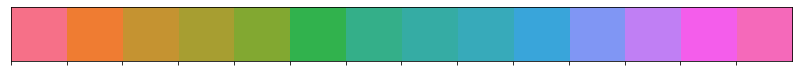

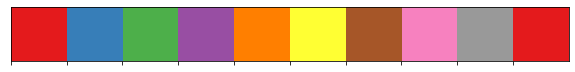

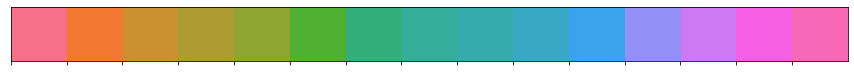

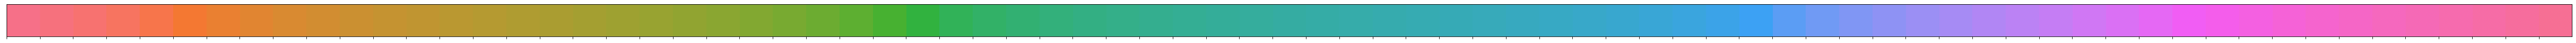

In [5]:
# Set microbe (column) colors
df = agora_tax_df.fillna('')
c = ['phylum', 'gram', 'oxygenstat', 'metabolism']
p = ['husl', 'Set1', 'husl', 'husl']
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
col_colors = [[palettes[i][df.loc[x, c[i]]] for x in df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

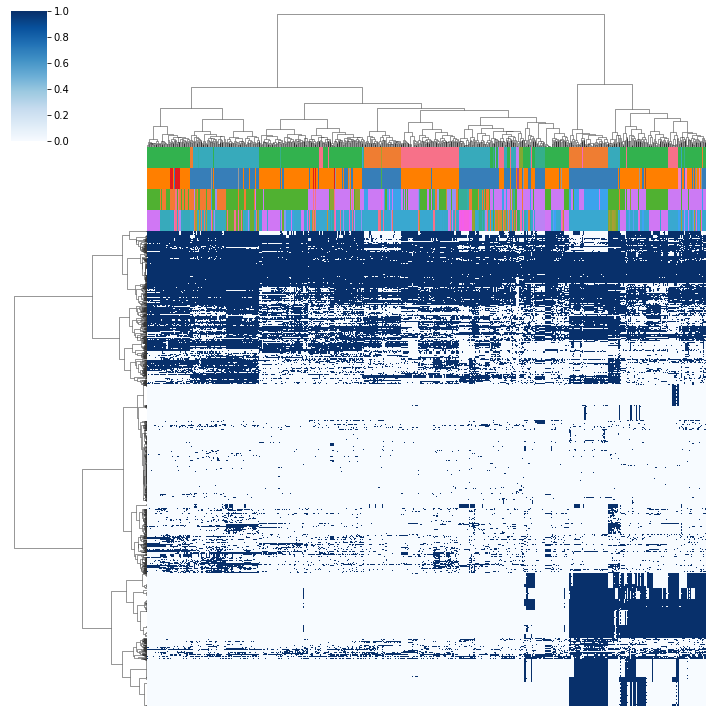

In [6]:
g = sns.clustermap(rxn_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, col_colors=col_colors)
g.savefig(join(plot_dir, 'clustermap_agora.png'), bbox_inches='tight')

In [7]:
# Choose suffix indicating whose data is used ("jeleel" or "pabo")
suffix = 'pabo'

In [8]:
# Load sample data
df = pd.read_csv(data_dir + '/metadata_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
sample_df = df.loc[:, df.isna().sum() < 95]
sample_df

diet  dn       sample_type fish_number  tank  quant_reading  \
S1       FP   9           control          FP   NaN             20   
S10      IO   5           Digesta          32   7.0              8   
S11      EX   6           Digesta          37   8.0              5   
S12      EX   6           Digesta          38   8.0              6   
S13      IM   2           Digesta           1   2.0             74   
..      ...  ..               ...         ...   ...            ...   
S94    DCIM   4           Digesta         101  18.0            129   
S95    DFIM   3              Feed         D3B   NaN             84   
S96    DCIM   4              Feed         D4B   NaN            192   
S88  Mock_1   7  Positive_control         PC1   NaN            247   
S89  Mock_2   7  Positive_control         PC2   NaN            162   

          sample_kind  
S1   Negative_control  
S10       True_sample  
S11       True_sample  
S12       True_sample  
S13       True_sample  
..                ...  
S94       True_sample  
S95       Feed_sample  
S96       Feed_sample  
S88       True_sample  
S89       True_sample  

[96 rows x 7 columns]

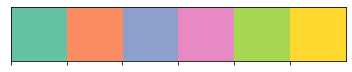

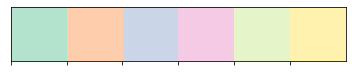

In [9]:
# Define diet order and palette
diet_order = {
    'pabo': ['CD', 'IM', 'DFIM', 'DCIM', 'IO', 'EX'],
    'jeleel': ['FM', 'ICJ', 'ACJ', 'IWA', 'AWA', 'SBM']
}
diet_palette = sns.color_palette('Set2', len(diet_order[suffix]))
diet_palette_pale = sns.color_palette('Pastel2', len(diet_order[suffix]))
sns.palplot(diet_palette)
sns.palplot(diet_palette_pale)

In [10]:
# Get digesta samples
digesta = sample_df.sample_type == 'Digesta'

In [11]:
# Load taxonomy data
df = pd.read_csv(data_dir + '/tax_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
tax_df = df
tax_df

kingdom  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...  Bacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...  Bacteria   
...                                                      ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...  Bacteria   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...  Bacteria   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Bacteria   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...  Bacteria   

                                                               phylum  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...   Actinobacteriota   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Proteobacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...     Proteobacteria   
...                                                               ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...       Dependentiae   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...   Actinobacteriota   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Verrucomicrobiota   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...     Proteobacteria   

                                                                  class  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...       Actinobacteria   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...  Gammaproteobacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...  Alphaproteobacteria   
...                                                                 ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...             Babeliae   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...       Coriobacteriia   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...     Verrucomicrobiae   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...  Alphaproteobacteria   

                                                                 order  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...     Lactobacillales   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...       Micrococcales   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Xanthomonadales   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...     Lactobacillales   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...    Sphingomonadales   
...                                                                ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...          Babeliales   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...    Coriobacteriales   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Chthoniobacterales   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...          Bacillales   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...         Rhizobiales   

                                                                 family  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...                  NaN   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...     Beutenbergiaceae   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Xanthomonadaceae   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...    Carnobacteriaceae   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...    Sphingomonadaceae   
...                                                                 ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...                  NaN   
TGGGGAATCTTGCGCAA

In [12]:
# Load count data
df = pd.read_csv(data_dir + '/count_table_' + suffix + '.csv', index_col=0)
cnt_df = df
cnt_df

TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAGAGAAGAACGACCTAGGTAGTAACTGATCTAGGAGTGACGGTATCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA  \
S1                                                   0                                                                                                                                                                                                                                                                                                                                                                                             
S10                                               3224                                                                                                                                                                                                                                                                                                                                                                                             
S11                                               2715                                                                                                                                                                                                                                                                                                                                                                                             
S12                                               4204                                                                                                                                                                                                                                                                                                                                                                                             
S13                                              39484                                                                                                                                                                                                                                                                                                                                                                                             
..                                                 ...                                                                                                                                                                                                                                                                                                                                                                                             
S94                                              10917                                                                                                                                                                                                                                                                                                                                                                                             
S95                                               3107                                                                                                                                                                                                                                                                                                                                                                                             
S96                                               4688                           

Text(0.5, 0, 'Abundance (log10)')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


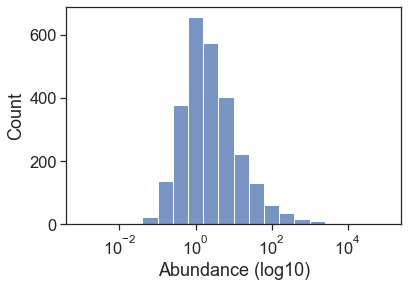

In [13]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(cnt_df.mean(), bins=20, binrange=(-3, 5), log_scale=True)
plt.xlabel('Abundance (log10)')

In [14]:
# Normalize counts to fraction
frac_df = cnt_df.T / cnt_df.sum(1)
frac_df = frac_df.T
frac_df

TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAGAGAAGAACGACCTAGGTAGTAACTGATCTAGGAGTGACGGTATCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA  \
S1                                            0.000000                                                                                                                                                                                                                                                                                                                                                                                             
S10                                           0.038963                                                                                                                                                                                                                                                                                                                                                                                             
S11                                           0.055051                                                                                                                                                                                                                                                                                                                                                                                             
S12                                           0.083778                                                                                                                                                                                                                                                                                                                                                                                             
S13                                           0.284043                                                                                                                                                                                                                                                                                                                                                                                             
..                                                 ...                                                                                                                                                                                                                                                                                                                                                                                             
S94                                           0.115099                                                                                                                                                                                                                                                                                                                                                                                             
S95                                           0.059805                                                                                                                                                                                                                                                                                                                                                                                             
S96                                           0.129757                           

Text(0.5, 0, 'Fraction (log10)')

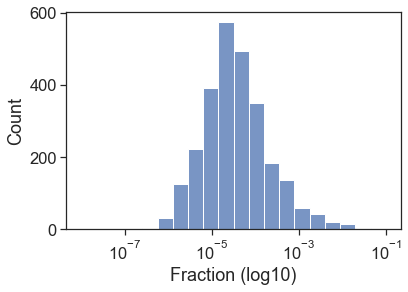

In [15]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(frac_df.mean(), bins=20, binrange=(-8, -1), log_scale=True)
plt.xlabel('Fraction (log10)')

Text(0, 0.5, 'Fraction (log10)')

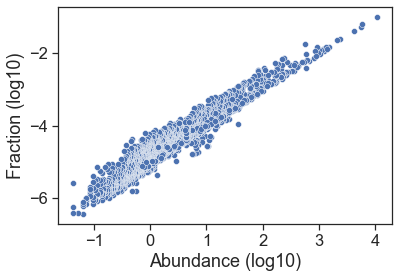

In [16]:
sns.set(style='ticks', font_scale=1.5)
sns.scatterplot(np.log10(cnt_df.mean()), np.log10(frac_df.mean()))
plt.xlabel('Abundance (log10)')
plt.ylabel('Fraction (log10)')

In [17]:
sample_df.nunique()

diet             11
dn                9
sample_type       5
fish_number      96
tank             18
quant_reading    82
sample_kind       4
dtype: int64

In [18]:
tax_df.nunique()

kingdom      2
phylum      26
class       50
order      151
family     231
genus      512
species    236
dtype: int64

In [19]:
# Choose sample variables and palettes
c = ['diet', 'tank']
p = ['husl', 'Blues']

['Acidobacteriota', 'Actinobacteriota', 'Armatimonadota', 'Bacteroidota', 'Bdellovibrionota', 'Campylobacterota', 'Chloroflexi', 'Cyanobacteria', 'Deinococcota', 'Dependentiae', 'Desulfobacterota', 'Elusimicrobiota', 'Firmicutes', 'Fusobacteriota', 'Gemmatimonadota', 'Myxococcota', 'NB1-j', 'Nanoarchaeota', 'Nitrospirota', 'Patescibacteria', 'Planctomycetota', 'Proteobacteria', 'SAR324 clade(Marine group B)', 'Spirochaetota', 'Thermotogota', 'Verrucomicrobiota']
['CD', 'DCIM', 'DFIM', 'EX', 'FP', 'IM', 'IO', 'Mock_1', 'Mock_2', 'NC', 'TW']
[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


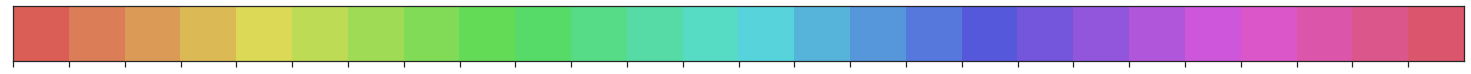

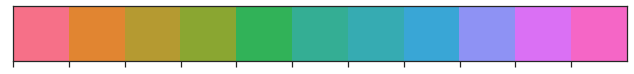

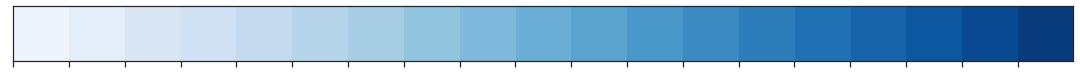

In [20]:
# Set microbe (column) colors
df = tax_df.fillna('')
rank = 'phylum'
palette = dict(zip(sorted(set(df[rank])), sns.color_palette('hls', len(set(df[rank])))))
col_colors = [palette[df.loc[x, rank]] for x in frac_df.columns]

sns.palplot(palette.values())
print(sorted(set(df[rank])))

# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

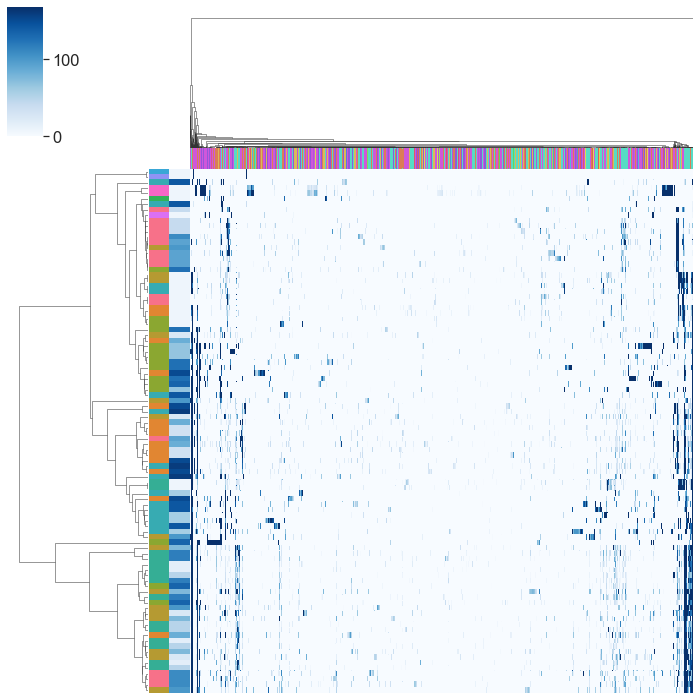

In [21]:
# Clustermap (counts)
g = sns.clustermap(cnt_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_cnt_' + suffix + '.png'), bbox_inches='tight')

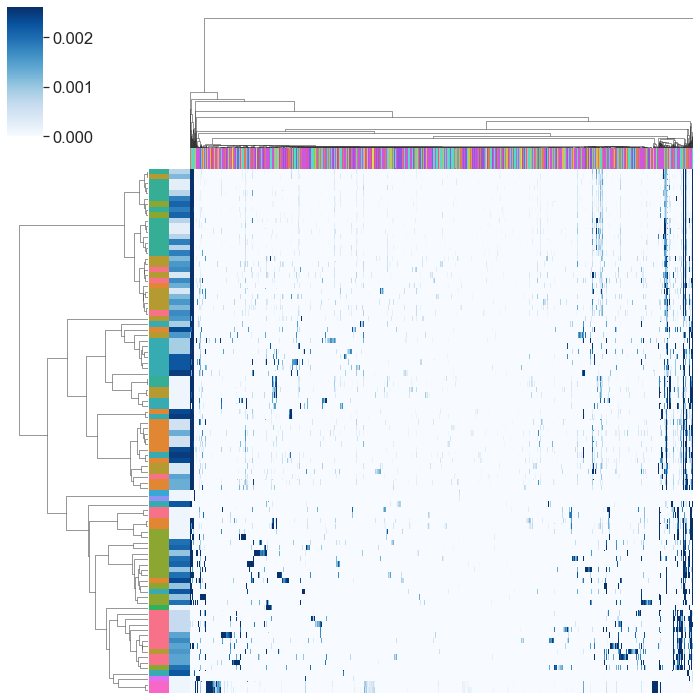

In [22]:
# Clustermap (fractions)
g = sns.clustermap(frac_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_frac_' + suffix + '.png'), bbox_inches='tight')

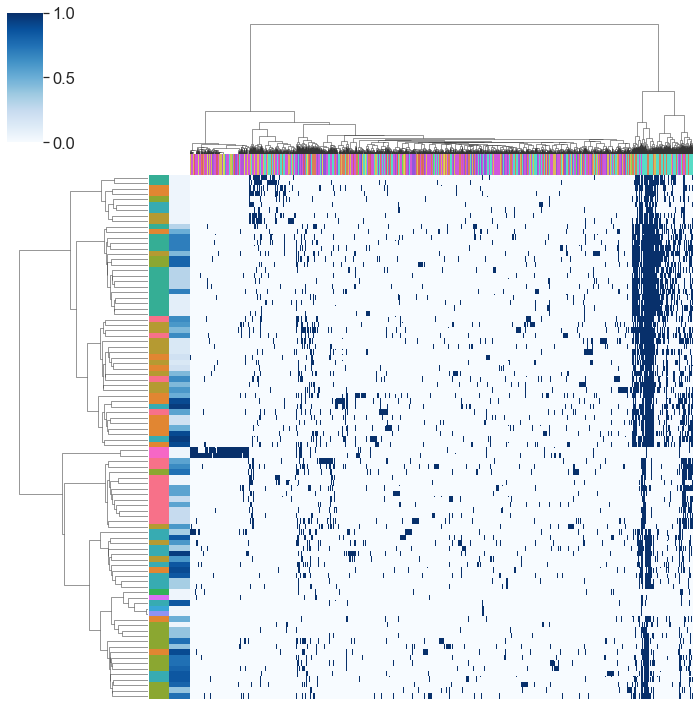

In [23]:
# Clustermap (binary)
g = sns.clustermap(frac_df > 0, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_bin_' + suffix + '.png'), bbox_inches='tight')

In [24]:
# PCA on counts
pca = PCA()
Z = StandardScaler().fit_transform(frac_df[digesta])
T = pca.fit_transform(Z)
T.shape

(78, 78)

In [25]:
n = 5
sample_df.loc[digesta, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

diet  dn       sample_type fish_number  tank  quant_reading  \
S1       FP   9           control          FP   NaN             20   
S10      IO   5           Digesta          32   7.0              8   
S11      EX   6           Digesta          37   8.0              5   
S12      EX   6           Digesta          38   8.0              6   
S13      IM   2           Digesta           1   2.0             74   
..      ...  ..               ...         ...   ...            ...   
S94    DCIM   4           Digesta         101  18.0            129   
S95    DFIM   3              Feed         D3B   NaN             84   
S96    DCIM   4              Feed         D4B   NaN            192   
S88  Mock_1   7  Positive_control         PC1   NaN            247   
S89  Mock_2   7  Positive_control         PC2   NaN            162   

          sample_kind       pc1       pc2       pc3       pc4       pc5  
S1   Negative_control       NaN       NaN       NaN       NaN       NaN  
S10       True_sample -3.195305  0.208944 -2.789589  0.094879 -1.494082  
S11       True_sample  1.306497  1.450820  3.732147 -1.997530  1.705383  
S12       True_sample -0.135329 -1.400813  2.858167 -0.957744  1.043439  
S13       True_sample -7.013416 -3.764866 -2.837569  1.450113 -0.477276  
..                ...       ...       ...       ...       ...       ...  
S94       True_sample -5.137758 -3.578467 -1.757482  1.360205 -1.245999  
S95       Feed_sample       NaN       NaN       NaN       NaN       NaN  
S96       Feed_sample       NaN       NaN       NaN       NaN       NaN  
S88       True_sample       NaN       NaN       NaN       NaN       NaN  
S89       True_sample       NaN       NaN       NaN       NaN       NaN  

[96 rows x 12 columns]

No handles with labels found to put in legend.


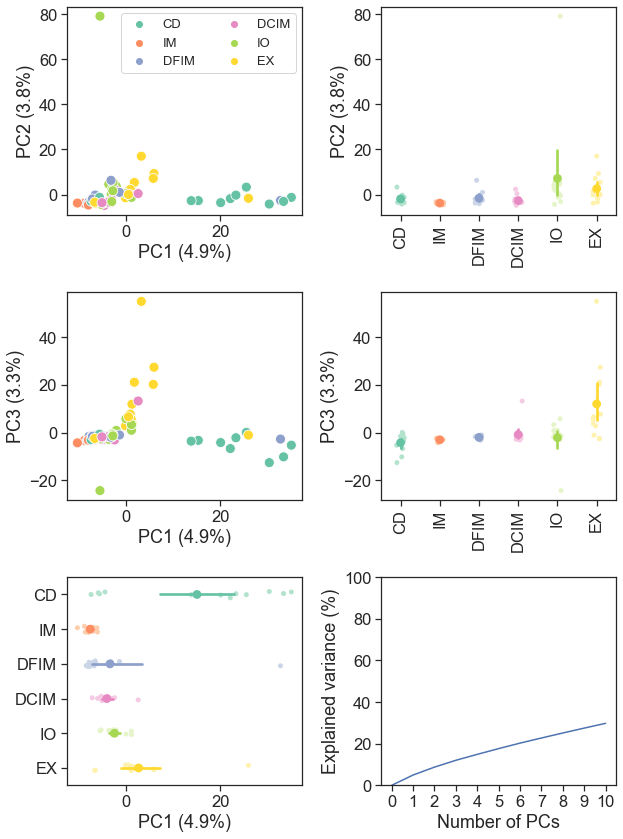

In [26]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[digesta]
order = diet_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=2, fontsize=13).set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.diet, y=df.pc2, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc2, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend().set_visible(False)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.diet, y=df.pc3, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc3, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.diet, x=df.pc1, join=False, palette=diet_palette, orient='h', order=order)
ax = sns.stripplot(y=df.diet, x=df.pc1, palette=diet_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x, y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_cnt_' + suffix + '.pdf'), bbox_inches='tight')

In [27]:
# Map samples to models (fast)

mapping = {}
matches = []
models = []

for i, row in tax_df.iterrows():
    if row.family == np.nan or row.family not in set(agora_tax_df.family):
        matches.append(np.nan)
        models.append(0)
        continue
    
    df = agora_tax_df[agora_tax_df.family == row.family]
    m = 'family'
    for rank in ('genus', 'species'):
        if row[rank] in set(df[rank]):
            df = df[df[rank] == row[rank]]
            m = rank
    
    mapping[row.name] = list(df.index)
    matches.append(m.capitalize())
    models.append(len(df))

tax_df['match'] = matches
tax_df['models'] = models
tax_df

kingdom  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...  Bacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...  Bacteria   
...                                                      ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...  Bacteria   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...  Bacteria   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Bacteria   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...  Bacteria   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...  Bacteria   

                                                               phylum  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...   Actinobacteriota   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Proteobacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...     Proteobacteria   
...                                                               ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...       Dependentiae   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...   Actinobacteriota   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Verrucomicrobiota   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...         Firmicutes   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...     Proteobacteria   

                                                                  class  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...       Actinobacteria   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...  Gammaproteobacteria   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...  Alphaproteobacteria   
...                                                                 ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...             Babeliae   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...       Coriobacteriia   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...     Verrucomicrobiae   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...              Bacilli   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...  Alphaproteobacteria   

                                                                 order  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...     Lactobacillales   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...       Micrococcales   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Xanthomonadales   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...     Lactobacillales   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...    Sphingomonadales   
...                                                                ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...          Babeliales   
TGGGGAATCTTGCGCAATGGGGGAAACCCTGACGCAGCGACGCCGCG...    Coriobacteriales   
TCGAGAATTTTTCTCAATGGGGGAAACCCTGAAGGAGCGACGCCGCG...  Chthoniobacterales   
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCG...          Bacillales   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCG...         Rhizobiales   

                                                                 family  \
TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCG...                  NaN   
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCG...     Beutenbergiaceae   
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCG...     Xanthomonadaceae   
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCG...    Carnobacteriaceae   
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCG...    Sphingomonadaceae   
...                                                                 ...   
TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCG...                  NaN   
TGGGGAATCTTGCGCAA

In [28]:
sns.set(font_scale=1.5, style='ticks')
df = tax_df
df = df.sort_values(by='match')

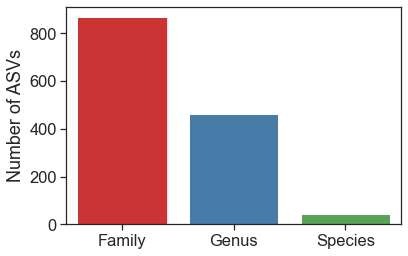

In [29]:
# Plot taxonomic level of match for each ASV
f = plt.figure()

ax = sns.countplot(df.match, palette='Set1')

plt.xlabel('Taxonomic level of model match')
plt.xlabel('')
plt.ylabel('Number of ASVs')

f.savefig(join(plot_dir, 'match_level_asv_' + suffix + '.pdf'), bbox_inches='tight')

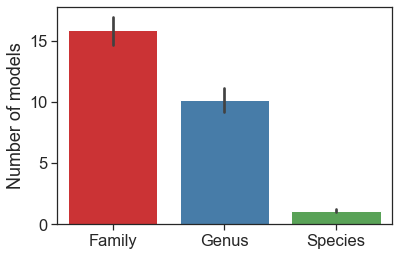

In [30]:
# Plot number of models mapped to each ASV by taxonomic level of match
f = plt.figure()

df = df[df.models > 0]
ax = sns.barplot(df.match, df.models, palette='Set1')

plt.xlabel('')
plt.ylabel('Number of models')

f.savefig(join(plot_dir, 'match_level_models_' + suffix + '.pdf'), bbox_inches='tight')

In [31]:
# Get fraction of models containing each reaction for each ASV
d = {}
for k, models in mapping.items():
    d[k] = rxn_df.iloc[:, models].mean(1)
asv_rxn_df = pd.DataFrame(d)
asv_rxn_df.to_csv(data_dir + '/asv_reactions_' + suffix + '.csv')
asv_rxn_df

TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTTGTCCGGAAAGAAATCCCAAAGGTTAATACCTTTTGGGGATGACGGTACCGGAAGAATAAGCACCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGTTTGTTAAGTCTGATGTGAAATCCCCGGGCTCAACCTGGGACCTGCATTGGATACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTCCCGGTGTAGCAGTGAAATGCGTAGAGATCGGGAGGAACACTCGTGGCGAAGGCGGCCACCTGGACCAGTACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACA  \
23DHMPO                                                  1.0                                                                                                                                                                                                                                                                                                                                                                                             
26DAPLLAT                                                1.0                                                                                                                                                                                                                                                                                                                                                                                             
2AHBUTI                                                  1.0                                                                                                                                                                                                                                                                                                                                                                                             
2MBCOATA                                                 1.0                                                                                                                                                                                                                                                                                                                                                                                             
3HAD10M12                                                1.0                                                                                                                                                                                                                                                                                                                                                                                             
...                                                      ...                                                                                                                                                                                                                                                                                                                                                                                             
HICITD                                                   0.0                                                                                                                                                                                                                                                                                                                                                                                             
OXAG                                                     0.0                                                                                                                                                                                                                                                                                                                                                                                             
US7P1PT                          

In [32]:
# Calculate and save reaction abundances
rxn_cnt_df = cnt_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_frac_df = frac_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_cnt_df.T.to_csv(data_dir + '/reaction_counts_' + suffix + '.csv')
rxn_frac_df.T.to_csv(data_dir + '/reaction_frac_' + suffix + '.csv')

In [33]:
# Choose sample variables and palettes
c = ['diet', 'tank']
p = ['husl', 'Blues']

['CD', 'DCIM', 'DFIM', 'EX', 'FP', 'IM', 'IO', 'Mock_1', 'Mock_2', 'NC', 'TW']
[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


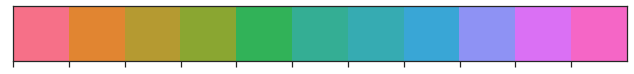

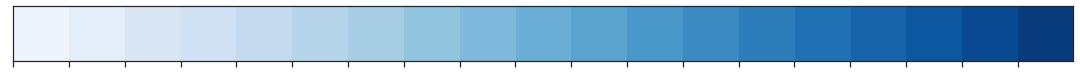

In [34]:
# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in rxn_frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

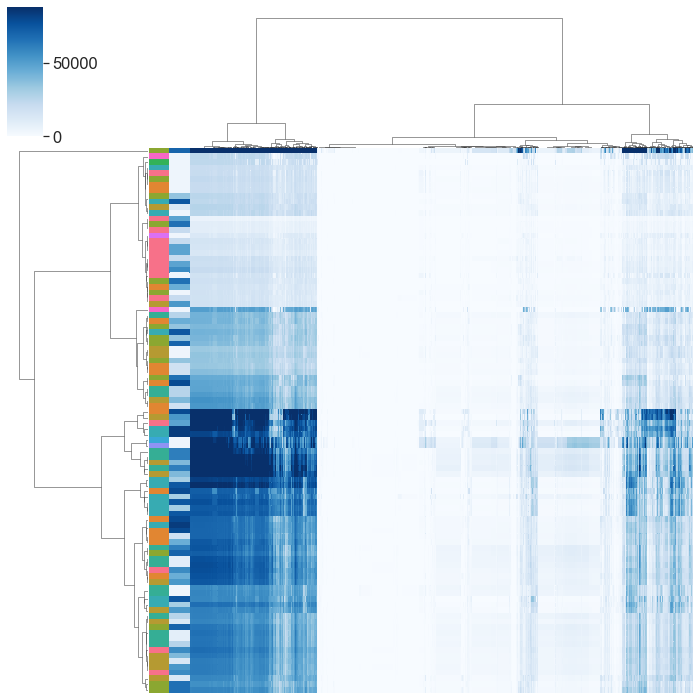

In [35]:
g = sns.clustermap(rxn_cnt_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, robust=True, row_colors=row_colors)
g.savefig(join(plot_dir, 'clustermap_rxn_cnt_' + suffix + '.png'), bbox_inches='tight')

In [36]:
# PCA on reaction abundances
pca = PCA()
Z = StandardScaler().fit_transform(rxn_frac_df[digesta])
T = pca.fit_transform(Z)
T.shape

(78, 78)

In [37]:
n = 5
sample_df.loc[digesta, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

diet  dn       sample_type fish_number  tank  quant_reading  \
S1       FP   9           control          FP   NaN             20   
S10      IO   5           Digesta          32   7.0              8   
S11      EX   6           Digesta          37   8.0              5   
S12      EX   6           Digesta          38   8.0              6   
S13      IM   2           Digesta           1   2.0             74   
..      ...  ..               ...         ...   ...            ...   
S94    DCIM   4           Digesta         101  18.0            129   
S95    DFIM   3              Feed         D3B   NaN             84   
S96    DCIM   4              Feed         D4B   NaN            192   
S88  Mock_1   7  Positive_control         PC1   NaN            247   
S89  Mock_2   7  Positive_control         PC2   NaN            162   

          sample_kind        pc1        pc2        pc3        pc4        pc5  
S1   Negative_control        NaN        NaN        NaN        NaN        NaN  
S10       True_sample  80.540505  35.949381 -17.654952 -28.109773  -7.085948  
S11       True_sample   2.702889  -1.851893  10.128450  -0.408495   6.965861  
S12       True_sample  27.006978   1.401495   7.870310  -6.176403  26.640825  
S13       True_sample -59.634981   4.672955  -3.618682  -2.716001  -6.483177  
..                ...        ...        ...        ...        ...        ...  
S94       True_sample   2.474760  11.048100 -21.882901  11.631864   4.868739  
S95       Feed_sample        NaN        NaN        NaN        NaN        NaN  
S96       Feed_sample        NaN        NaN        NaN        NaN        NaN  
S88       True_sample        NaN        NaN        NaN        NaN        NaN  
S89       True_sample        NaN        NaN        NaN        NaN        NaN  

[96 rows x 12 columns]

No handles with labels found to put in legend.


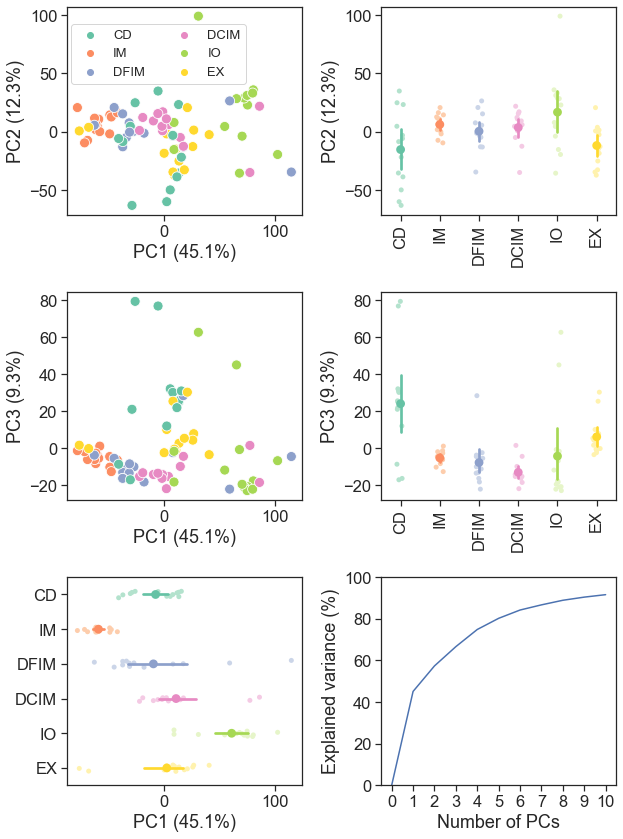

In [38]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[digesta]
order = diet_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=2, fontsize=13, loc=(0.02, 0.63)).set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.diet, y=df.pc2, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc2, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend().set_visible(False)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.diet, y=df.pc3, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc3, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.diet, x=df.pc1, join=False, palette=diet_palette, orient='h', order=order)
ax = sns.stripplot(y=df.diet, x=df.pc1, palette=diet_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x, y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_rxn_' + suffix + '.pdf'), bbox_inches='tight')

In [39]:
# Choose multiple testing correction method
method = 'fdr_bh'

In [40]:
# Pairwise comparison of diets for each reaction

d = defaultdict(list)
df = sample_df[digesta]

for x1, x2 in combinations(diet_order[suffix], 2):
    print(x1, x2)
    for r in rxn_frac_df.columns:
        if r.startswith('EX_') or r.startswith('sink_') or r.startswith('DM_') or r.startswith('biomass'):
            continue
        
        s = subsys[r]
        if not s or s.startswith('Transport') or s.startswith('Exchange') or s.startswith('Unassigned'):
            continue

        s1 = rxn_frac_df.loc[df[df.diet == x1].index, r]
        s2 = rxn_frac_df.loc[df[df.diet == x2].index, r]
        t, p = ttest_ind(s1, s2, equal_var=False)
        d['x1'].append(x1)
        d['x2'].append(x2)
        d['t'].append(t)
        d['p'].append(p)
        d['reaction'].append(r)
        d['subsys'].append(s)
        
rxn_comp_df = pd.DataFrame(d).dropna()

rxn_comp_df

CD IM
CD DFIM
CD DCIM
CD IO
CD EX
IM DFIM
IM DCIM
IM IO
IM EX
DFIM DCIM
DFIM IO
DFIM EX
DCIM IO
DCIM EX
IO EX


x1  x2         t         p      reaction  \
0      CD  IM  0.394442  0.698156       23DHMPO   
1      CD  IM  0.181307  0.858358     26DAPLLAT   
2      CD  IM  0.394442  0.698156       2AHBUTI   
3      CD  IM  2.755459  0.013525      2MBCOATA   
4      CD  IM  2.739197  0.014005     3HAD10M12   
...    ..  ..       ...       ...           ...   
52429  IO  EX  0.653002  0.520440  L2AADIPADOR2   
52430  IO  EX  0.653002  0.520440         r0594   
52431  IO  EX -1.041964  0.317292          SQLE   
52432  IO  EX -0.418487  0.680468        INOSTO   
52437  IO  EX  1.000000  0.337049       US7P1PT   

                                           subsys  
0      Valine, leucine, and isoleucine metabolism  
1                               Lysine metabolism  
2      Valine, leucine, and isoleucine metabolism  
3                  Glycerophospholipid metabolism  
4                            Fatty acid synthesis  
...                                           ...  
52429                           Lysine metabolism  
52430                           Lysine metabolism  
52431                      Cholesterol metabolism  
52432               Inositol phosphate metabolism  
52437                   Pentose phosphate pathway  

[51616 rows x 6 columns]

In [41]:
# Correct for multiple testing and save
alpha = 0.05
rxn_comp_df['padj'] = multipletests(rxn_comp_df.p, method=method)[1]
rxn_comp_df.to_csv(data_dir + '/reaction_comp.csv')
(rxn_comp_df.padj < alpha).sum()

23058

In [42]:
# Subsystem enrichment analysis (Fisher's exact test)

dd = defaultdict(list)

for x, df in rxn_comp_df.groupby(['x1', 'x2']):
    for s in sorted(set(df.subsys)):
        a = ((df.subsys == s) & (df.padj <= alpha)).sum()
        b = ((df.subsys != s) & (df.padj <= alpha)).sum()
        c = ((df.subsys == s) & (df.padj > alpha)).sum()
        d = ((df.subsys != s) & (df.padj > alpha)).sum()
        n = a + b + c + d
        
        r, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        
        dd['x1'].append(x[0])
        dd['x2'].append(x[1])
        dd['subsys'].append(s)
        dd['a'].append(a)
        dd['b'].append(b)
        dd['c'].append(c)
        dd['d'].append(d)
        dd['n'].append(n)
        dd['r'].append(r)
        dd['p'].append(p)
        
        if p <= alpha:
            print(x, s, p)
            print(a, b, c, d)
        
subsys_comp_df = pd.DataFrame(dd)

subsys_comp_df

('CD', 'DCIM') Cell wall biosynthesis 0.006397478067206564
51 1437 39 1916
('CD', 'DCIM') Citric acid cycle 0.03396477664686871
24 1464 17 1938
('CD', 'DCIM') CoA synthesis 0.0013727347829362553
12 1476 2 1953
('CD', 'DCIM') Fatty acid synthesis 0.00012535938788439796
110 1378 86 1869
('CD', 'DCIM') Folate metabolism 0.00045412826106121874
27 1461 11 1944
('CD', 'DCIM') Glycerophospholipid metabolism 0.0033790287641574848
130 1358 122 1833
('CD', 'DCIM') Heme synthesis 0.000223449092279598
10 1478 0 1955
('CD', 'DCIM') Histidine metabolism 0.002193346667752812
16 1472 5 1950
('CD', 'DCIM') Methionine and cysteine metabolism 0.001897513654134213
29 1459 15 1940
('CD', 'DCIM') Nucleotide interconversion 0.008388728782452419
53 1435 42 1913
('CD', 'DCIM') Nucleotide salvage pathway 0.034807125482825094
4 1484 0 1955
('CD', 'DCIM') Peptide metabolism 2.609077219621499e-07
18 1470 0 1955
('CD', 'DCIM') Purine synthesis 1.7810580758827124e-05
13 1475 0 1955
('CD', 'DCIM') Thiamine metabolism

('DFIM', 'EX') Naphthalene degradation 0.0013385043902413602
4 449 1 2981
('DFIM', 'EX') Nucleotide sugar metabolism 0.017358396512618824
2 451 0 2982
('DFIM', 'EX') Pentose and glucuronate interconversions 0.03345581336338277
9 444 26 2956
('DFIM', 'EX') Plant polysaccharide degradation 0.015005514339589254
10 443 26 2956
('DFIM', 'EX') Polycyclic aromatic hydrocarbon degradation 0.017358396512618824
2 451 0 2982
('DFIM', 'EX') Starch and sucrose metabolism 2.360020569307153e-07
21 432 28 2954
('DFIM', 'IO') Cell wall biosynthesis 1.6097506202282678e-06
78 2140 12 1209
('DFIM', 'IO') Fatty acid synthesis 6.7647192240957956e-09
162 2056 34 1187
('DFIM', 'IO') Glycerophospholipid metabolism 4.338979293345064e-05
191 2027 61 1160
('DFIM', 'IO') Heme synthesis 0.012363969310178975
10 2208 0 1221
('DFIM', 'IO') Histidine metabolism 0.02944686672962969
18 2200 3 1218
('DFIM', 'IO') Mucin O-glycan degradation 4.6182282372510564e-27
835 1383 247 974
('DFIM', 'IO') Peptide metabolism 0.0003637

x1    x2                            subsys   a     b   c     d     n  \
0     CD  DCIM  Alanine and aspartate metabolism   9  1479  11  1944  3443   
1     CD  DCIM                Alkaloid synthesis   0  1488   1  1954  3443   
2     CD  DCIM         Aminobenzoate degradation   2  1486   1  1954  3443   
3     CD  DCIM       Aminophosphonate metabolism   0  1488   1  1954  3443   
4     CD  DCIM             Aminosugar metabolism  16  1472  11  1944  3443   
...   ..   ...                               ...  ..   ...  ..   ...   ...   
1435  IO    EX             Vitamin B6 metabolism   8  1581   9  1843  3441   
1436  IO    EX              Vitamin C metabolism   0  1589   1  1851  3441   
1437  IO    EX            Wood-Ljungdahl Pathway   0  1589   6  1846  3441   
1438  IO    EX           beta-Alanine metabolism   4  1585   4  1848  3441   
1439  IO    EX                     tRNA Charging   2  1587   0  1852  3441   

             r         p  
0     1.075420  0.521703  
1     0.000000  1.000000  
2     2.629879  0.398867  
3     0.000000  1.000000  
4     1.920949  0.068228  
...        ...       ...  
1435  1.036194  0.565073  
1436  0.000000  1.000000  
1437  0.000000  1.000000  
1438  1.165931  0.550520  
1439       inf  0.213173  

[1440 rows x 10 columns]

In [43]:
# Correct for multiple testing and save
alpha = 0.05
subsys_comp_df['padj'] = multipletests(subsys_comp_df.p, method=method)[1]
subsys_comp_df.to_csv(data_dir + '/subsys_comp.csv')
(subsys_comp_df.padj < alpha).sum()

88

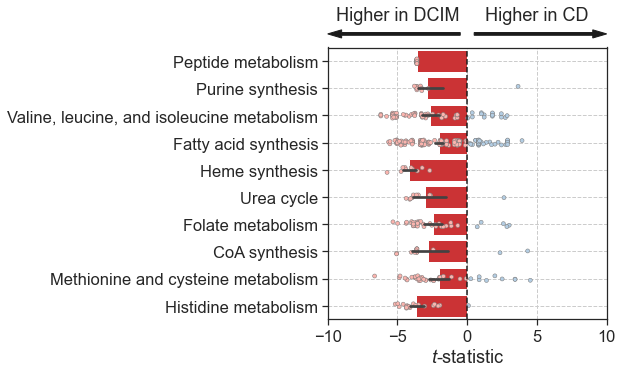

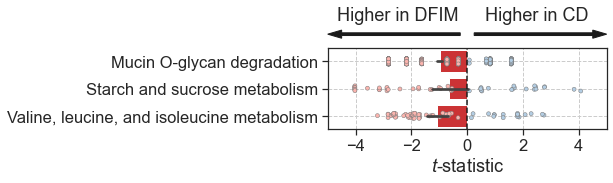

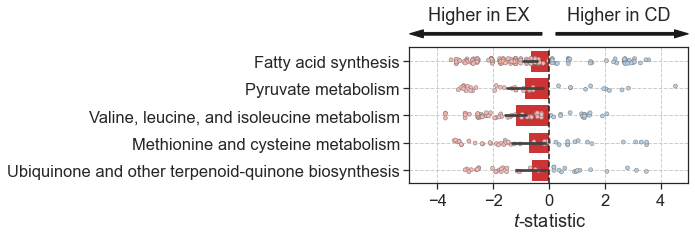

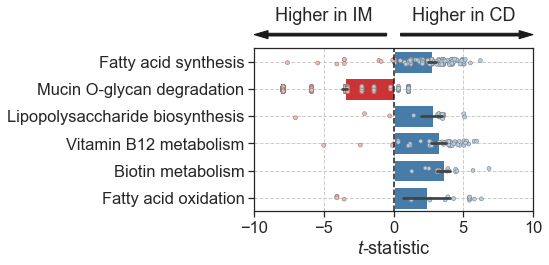

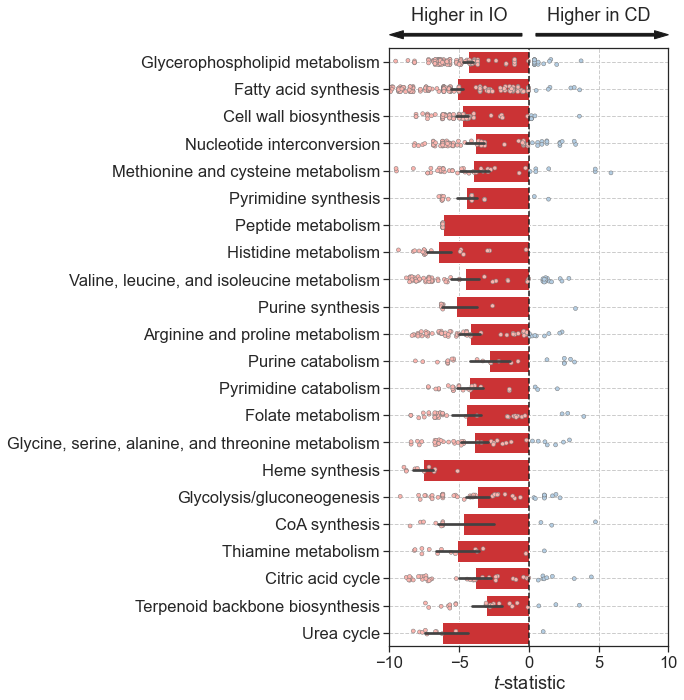

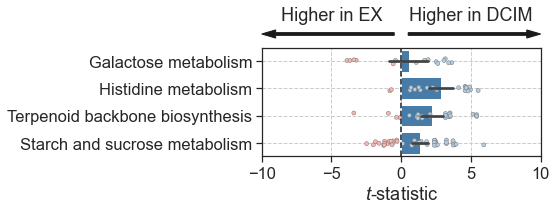

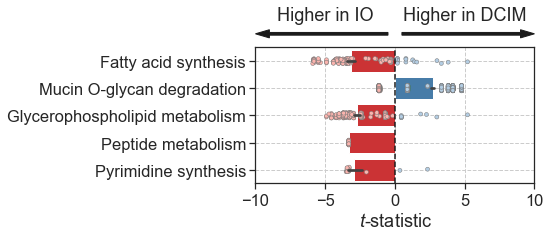

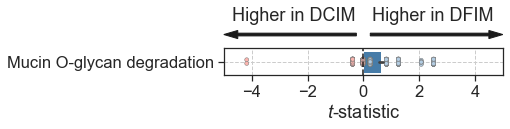

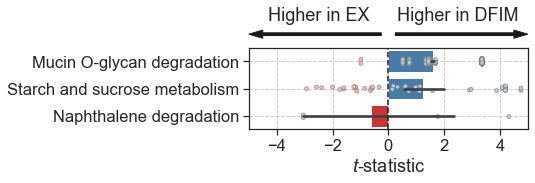

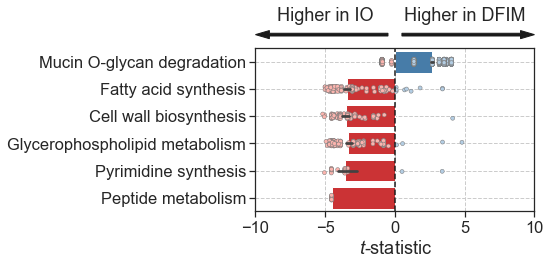

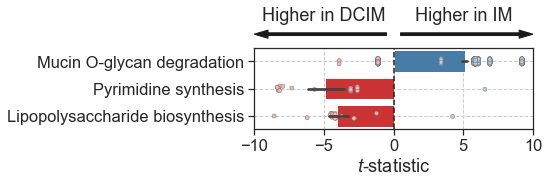

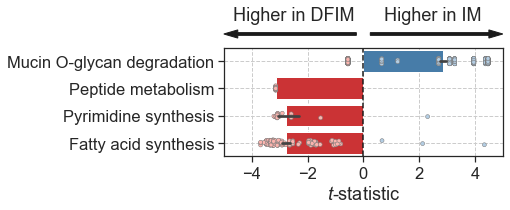

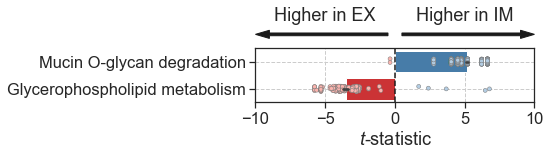

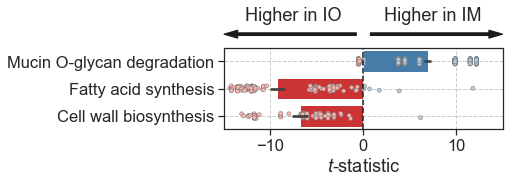

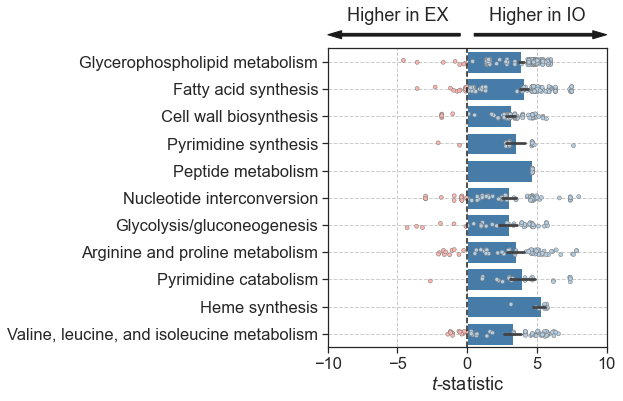

In [44]:
# Plot t-statistic for each reaction, significant subsystem, and diet pair
sns.set(style='ticks', font_scale=1.5)

alpha = 0.05

for x, df in rxn_comp_df.dropna().groupby(['x1', 'x2']): 
#     df = df[(df.subsys != '') & (df.padj < alpha)]
    df = df[(df.subsys != '')]
    
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x[0]) & (ss_df.x2 == x[1]) & (ss_df.padj <= alpha)]
    ss = set(ss_df.subsys)
    
    df = df[df.subsys.isin(ss)]
    
    if df.empty:
        continue
    
    f = plt.figure()
    
    xmax = df.t.abs().max()
    xmax = np.ceil(df.t.abs().max() / 5) * 5
    xlim = -xmax, xmax
    ylim = df.subsys.nunique() - 0.5, -0.5
        
#     s = df[df.t < 0].subsys.value_counts().sort_values(ascending=False)
#     ax = plt.barh(y=s.index, width=-s.values)

#     s = df[df.t > 0].subsys.value_counts().sort_values(ascending=False)
#     plt.barh(y=s.index, width=s.values)
    t_mean = df.groupby('subsys').t.mean()
    order = list(t_mean.sort_values(ascending=True).index)
    hue = [dict(t_mean > 0)[x] for x in df.subsys] 
    
    p1 = sns.color_palette('Pastel1', 2)
    p2 = sns.color_palette('Set1', 2)
    if df.t.max() < 0:
        p1.pop()
    elif df.t.min() > 0:
        p1.pop(0)
    if t_mean.max() < 0:
        p2.pop()
    elif t_mean.min() > 0:
        p2.pop(0)
        
#     hue = df.t < 0
#     hue = df.t != 0
    
#     ss_df['recall'] = ss_df.a / ss_df[['a', 'c']].sum(1)
#     ss_df = ss_df.sort_values(by='recall', ascending=True)
#     order = ss_df.subsys
    order = ss_df.sort_values(by='padj', ascending=True).subsys

#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], hue=hue, palette='Set1', color='#b3cde3', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj > alpha], color='#f2f2f2', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, palette=['#999999', '#e41a1c'], size=2, order=order)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], color='#e41a1c', size=5, order=order)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, order=order, palette=['#d9d9d9', '#e41a1c'], size=2)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8')
    ax = sns.stripplot(x=df.t, y=df.subsys, hue=df.t > 0, palette=p1, jitter=0.1, order=order, size=4, zorder=2, linewidth=0.5)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8', ci=95, zorder=2)
    ax = sns.barplot(x=df.t, y=df.subsys, hue=hue, palette=p2, order=order, dodge=False, ci=95, zorder=1)
    
    plt.plot([0, 0], ylim, c='k', ls='--')
    
    plt.arrow(-0.05 * xmax, -1, -0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.arrow(0.05 * xmax, -1, 0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.text(-xmax / 2, -1.5, 'Higher in {}'.format(x[1]), ha='center')
    plt.text(xmax / 2, -1.5, 'Higher in {}'.format(x[0]), ha='center')

#     plt.title(' vs. '.join(x))
    plt.xlabel('Subsystem difference')
    plt.xlabel('$t$-statistic')
    plt.ylabel('')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True, ls='--')
    ax.legend().set_visible(False)
    
#     plt.subplot(1, 6, 4)
#     ax = plt.barh(y=ss_df.subsys, width=ss_df.recall, tick_label='')
    
    f.set_size_inches(5, len(set(df.subsys)) / 2)
    f.savefig(join(plot_dir, '_'.join(x).lower() + '_subsys_diff_' + suffix + '.pdf'), bbox_inches='tight')
#     break

In [45]:
# Compute mean t-statistic for each significant subsystem
d = defaultdict(dict)
alpha = 0.05
order = diet_order[suffix]
for (x1, x2), df in rxn_comp_df.groupby(['x1', 'x2']):
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x1) & (ss_df.x2 == x2) & (ss_df.padj <= alpha)]
    df = df[df.subsys.isin(set(ss_df.subsys))]
    if df.empty:
        continue
    for ss in df.subsys:
        d[(x1, x2)][ss] = df[df.subsys == ss].t.mean()
        d[(x2, x1)][ss] = -df[df.subsys == ss].t.mean()
df = pd.DataFrame(d).fillna(0)
df = df.loc[df.any(1)]
df = df[list(permutations(order, 2))]
df

CD            \
                                                          IM      DFIM   
Valine, leucine, and isoleucine metabolism          0.000000 -1.094697   
Fatty acid synthesis                                2.768688  0.000000   
Methionine and cysteine metabolism                  0.000000  0.000000   
CoA synthesis                                       0.000000  0.000000   
Purine synthesis                                    0.000000  0.000000   
Folate metabolism                                   0.000000  0.000000   
Peptide metabolism                                  0.000000  0.000000   
Histidine metabolism                                0.000000  0.000000   
Heme synthesis                                      0.000000  0.000000   
Urea cycle                                          0.000000  0.000000   
Mucin O-glycan degradation                         -3.504055 -0.991628   
Starch and sucrose metabolism                       0.000000 -0.635896   
Pyruvate metabolism                                 0.000000  0.000000   
Ubiquinone and other terpenoid-quinone biosynth...  0.000000  0.000000   
Vitamin B12 metabolism                              3.262809  0.000000   
Fatty acid oxidation                                2.398237  0.000000   
Biotin metabolism                                   3.595881  0.000000   
Lipopolysaccharide biosynthesis                     2.836958  0.000000   
Glycerophospholipid metabolism                      0.000000  0.000000   
Purine catabolism                                   0.000000  0.000000   
Cell wall biosynthesis                              0.000000  0.000000   
Nucleotide interconversion                          0.000000  0.000000   
Arginine and proline metabolism                     0.000000  0.000000   
Glycolysis/gluconeogenesis                          0.000000  0.000000   
Thiamine metabolism                                 0.000000  0.000000   
Glycine, serine, alanine, and threonine metabolism  0.000000  0.000000   
Pyrimidine synthesis                                0.000000  0.000000   
Terpenoid backbone biosynthesis                     0.000000  0.000000   
Pyrimidine catabolism                               0.000000  0.000000   
Citric acid cycle                                   0.000000  0.000000   
Galactose metabolism                                0.000000  0.000000   
Naphthalene degradation                             0.000000  0.000000   

                                                                        \
                                                        DCIM        IO   
Valine, leucine, and isoleucine metabolism         -2.640703 -4.615426   
Fatty acid synthesis                               -2.050661 -5.148211   
Methionine and cysteine metabolism                 -2.056766 -4.003973   
CoA synthesis                                      -2.780272 -4.756475   
Purine synthesis                                   -2.910800 -5.208006   
Folate metabolism                                  -2.472429 -4.529542   
Peptide metabolism                                 -3.606850 -6.174363   
Histidine metabolism                               -3.649818 -6.484265   
Heme synthesis                                     -4.139447 -7.602829   
Urea cycle                                         -3.017798 -6.228900   
Mucin O-glycan degradation                          0.000000  0.000000   
Starch and sucrose metabolism                       0.000000  0.000000   
Pyruvate metabolism                                 0.000000  0.000000   
Ubiquinone and other terpenoid-quinone biosynth...  0.000000  0.000000   
Vitamin B12 metabolism                              0.000000  0.000000   
Fatty acid oxidation                                0.000000  0.000000   
Biotin metabolism                                   0.000000  0.000000   
Lipopolysaccharide biosynthesis                     0.000000  0.000000   
Glycerophospholipid metabolism                      0.000000 

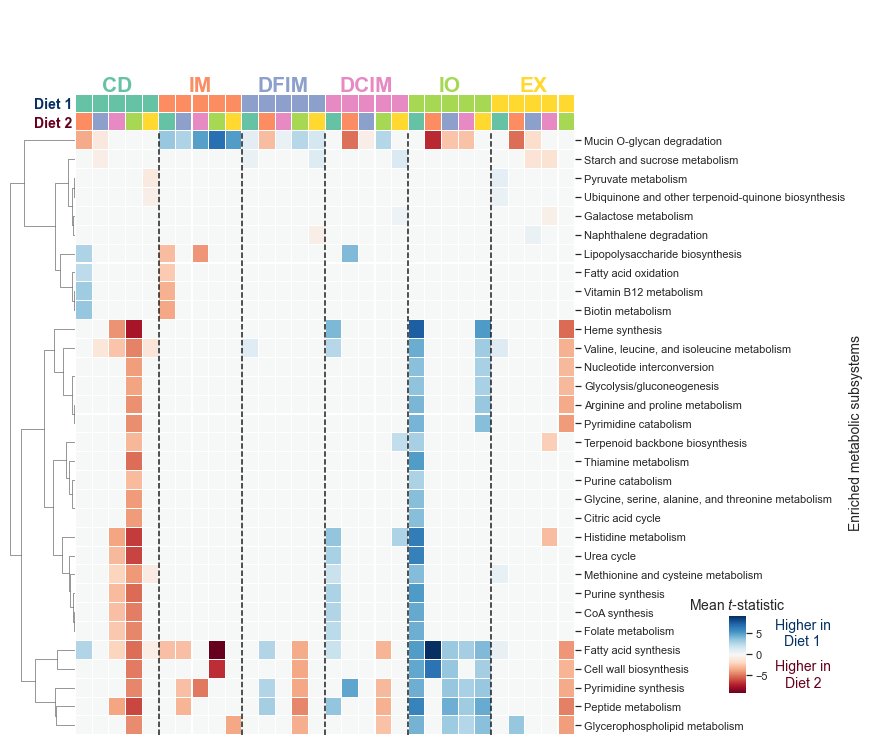

In [55]:
# Clustered heatmap of mean t-statistics (customized for data from Pabo)
if suffix == 'pabo':
    sns.set(font_scale=1)

    diets = diet_order[suffix]

    p = dict(zip(diets, diet_palette))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.85, 0.09, 0.02, 0.1)
    figsize=(12, len(df) / 3)
    dendrogram_ratio=0.12
    colors_ratio=0.025

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(diets) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, diet in enumerate(diets):
        g.ax_heatmap.text(2.5 + i * 5, -2.1, diet, ha='center', fontsize=fontsize * 1.5, color=p[diet], weight='bold')
    g.ax_heatmap.text(-2.5, -1.2, 'Diet 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'Diet 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(70, 5, 'Higher in\nDiet 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(70, -5, 'Higher in\nDiet 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.pdf'), bbox_inches='tight')

In [47]:
# Clustered heatmap of mean t-statistics (customized for data from Jeleel)
if suffix == 'jeleel':
    sns.set(font_scale=1)

    diets = diet_order[suffix]

    p = dict(zip(sorted(set(diets)), sns.color_palette('Set2', len(diets))))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.8, 0.72, 0.02, 0.175)
    figsize=(12, len(df) / 2)
    dendrogram_ratio=0.12
    colors_ratio=0.08

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(diets) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, diet in enumerate(diets):
        g.ax_heatmap.text(2.5 + i * 5, -2.2, diet, ha='center', fontsize=fontsize * 1.5, color=p[diet], weight='bold')
    g.ax_heatmap.text(-2.5, -1.2, 'Diet 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'Diet 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(250, 12, 'Higher in Diet 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(250, -12, 'Higher in Diet 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.pdf'), bbox_inches='tight')